In [1]:
import cv2, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For preprocessing
from skimage.filters import threshold_sauvola
from skimage.morphology import disk, square, remove_small_objects, opening
from skimage.util import invert

# Initialization / Loading data

In [2]:
# FIXME path containing testing / training data
test_path = '../Data/'
train_path = '../Data/TRAIN/'

# FIXME create results/train directory
!mkdir -p ../RESULTS/TRAIN/

# FIXME path of the results directory
output_path = '../RESULTS/'

In [3]:
def read_csv_or_none(csv_path):
    try:
        return pd.read_csv(csv_path, header=None)
    except:
        return None

In [4]:
def plot_img(img, gt=None, title='', cmap='gray', scatter=30):
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    
    if gt is not None:
        xs = list(gt[0])
        ys = list(gt[1])
        for idx in range(len(xs)):
            j, i = ys[idx], xs[idx]
            plt.scatter(j, i, color='r', s=scatter)

## Testing data

In [5]:
# Init testing data
test_img_list = []
test_csv_list = []
test_title_list = []

for file in glob.glob(test_path + '*.jpg'):
    test_img_list.append(cv2.imread(file))
    test_csv_list.append(read_csv_or_none(file[:-3] + 'csv'))
    test_title_list.append(file[:-4])
    
test_nb_images = len(test_img_list)
print('Testing dataset contains {} images'.format(test_nb_images))

Testing dataset contains 5 images


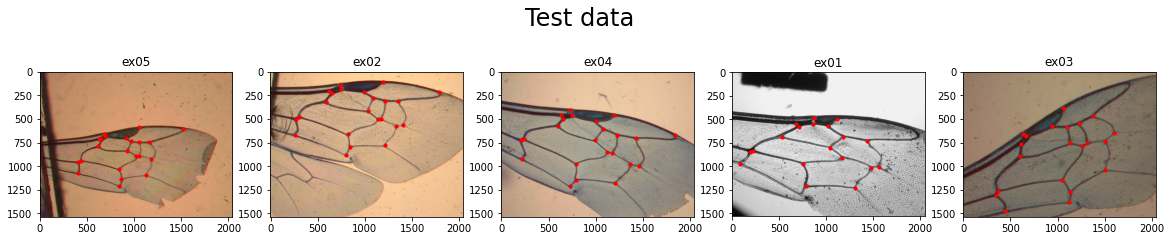

In [6]:
# Display images

plt.figure(figsize=(20, 4))
for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    
    plt.subplot(1, test_nb_images, i + 1)
    plot_img(test_img_list[i], test_csv_list[i], title, scatter=10)
    
plt.suptitle('Test data', fontsize=24)
plt.show()

## Training data

In [7]:
# Init training data
train_img_list = []
train_csv_list = []
train_title_list = []

for file in glob.glob(train_path + '*.jpg'):
    train_img_list.append(cv2.imread(file))
    train_csv_list.append(read_csv_or_none(file[:-3] + 'csv'))
    train_title_list.append(file[:-4])
    

train_nb_images = len(train_img_list)
print('Training dataset contains {} images'.format(train_nb_images))

Training dataset contains 32 images


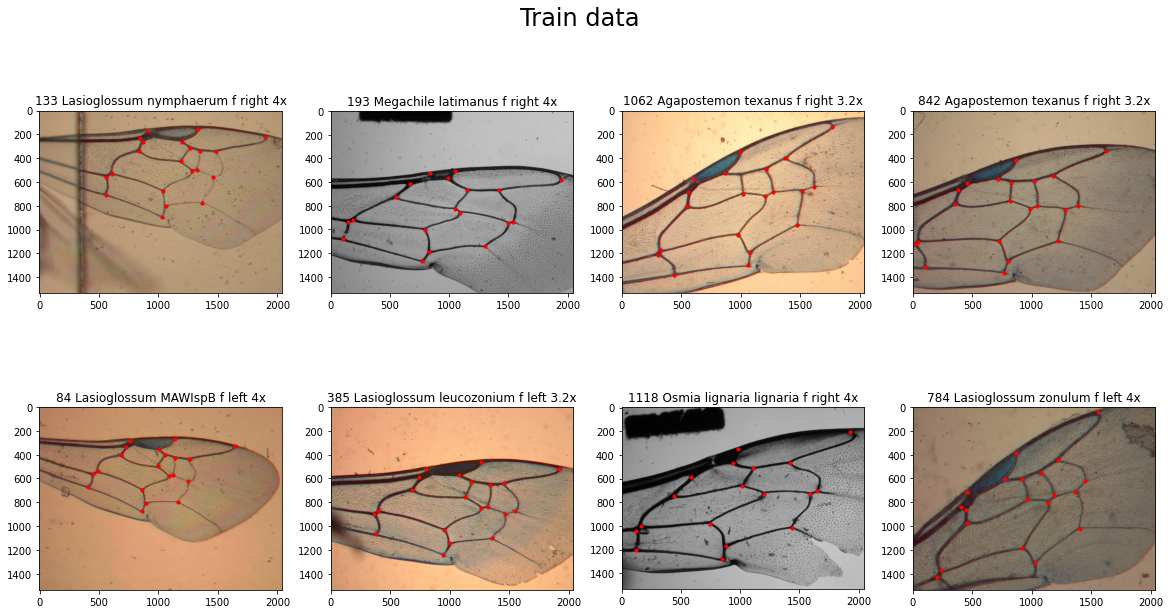

In [8]:
# Display first 8 images

plt.figure(figsize=(20, 10))
for i in range(8):
    title = train_title_list[i].split('/')[-1]
    
    plt.subplot(2, 4, i + 1)
    plot_img(train_img_list[i], train_csv_list[i], title, scatter=10)
    
plt.suptitle('Train data', fontsize=24)
plt.show()

# Image preprocessing

### Grayscale

In [9]:
def RGB_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### Threshold

In [10]:
def apply_threshold_sauvola(img):
    threshold_value = threshold_sauvola(img, 89, 0.15)
    return (img > threshold_value).astype(np.uint8)

### Remove small objects

In [11]:
def remove_small_obj(img, min_size):
    return remove_small_objects(img < 1, min_size=min_size)

### Opening

In [12]:
def apply_opening(img, footprint):
    return opening(img, footprint)

### Connected Components

In [13]:
def compute_connected_components(img):
    return cv2.connectedComponents(img.astype(np.uint8))[1]

## Preprocessing pipeline

In [14]:
def print_string_if_true(condition, string):
    if condition:
        print(string)

def apply_preprocessing(img, display=False, verbose=False):
    img_list = [img]
    
    print_string_if_true(verbose, "1 - RGB to gray")
    img_list.append(RGB_to_gray(img_list[-1]))
        
    print_string_if_true(verbose, "2 - Threshold")
    img_list.append(apply_threshold_sauvola(img_list[-1]))

    print_string_if_true(verbose, "3 - Opening")
    img_list.append(apply_opening(invert(img_list[-1]), square(1)))
    
    print_string_if_true(verbose, "4 - Remove small objects")
    img_list.append(remove_small_obj(invert(img_list[-1]), 20000))
    
    print_string_if_true(verbose, "5 - Remove small objects")
    img_list.append(remove_small_obj(img_list[-1], 1000))

    print_string_if_true(verbose, "6 - Opening")
    img_list.append(apply_opening(img_list[-1], disk(10)))
    
    print_string_if_true(verbose, "7 - Connected components")
    img_list.append(compute_connected_components(img_list[-1]))
    
    if display:
        plt.figure(figsize=(20, 10))
        
        plt.subplot(2, 4, 1)
        plt.imshow(img_list[0])
        plt.title('Original image')

        for i in range(1, 7):
            plt.subplot(2, 4, i + 1)
            plt.imshow(img_list[i], cmap='gray')
            plt.title('Step {}'.format(i))
        
        plt.subplot(2, 4, 8)
        plt.imshow(img_list[-1], cmap='turbo')
        plt.title('Step 7')

        plt.show()
    
    return img_list[-1]

1 - RGB to gray
2 - Threshold
3 - Opening
4 - Remove small objects
5 - Remove small objects
6 - Opening
7 - Connected components


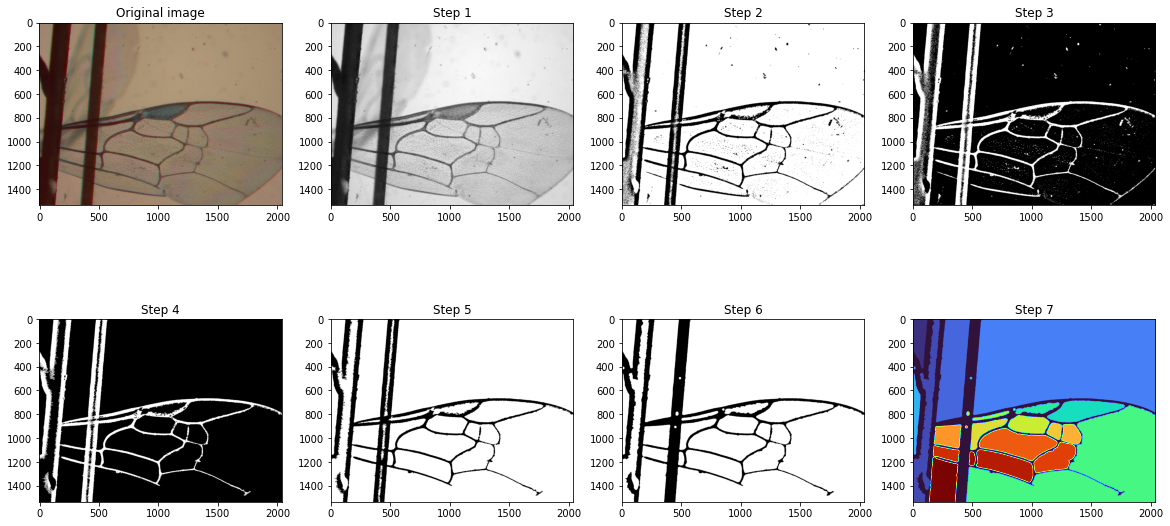

In [15]:
# Apply preprocessing for a random image of one of the datasets
_ = apply_preprocessing(train_img_list[-5], display=True, verbose=True)

## Testing data

In [16]:
test_preprocessed_img_list = []

for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    print('Apply preprocessing on {}'.format(title))
    
    preprocessed_img = apply_preprocessing(test_img_list[i])
    test_preprocessed_img_list.append(preprocessed_img)

Apply preprocessing on ex05
Apply preprocessing on ex02
Apply preprocessing on ex04
Apply preprocessing on ex01
Apply preprocessing on ex03


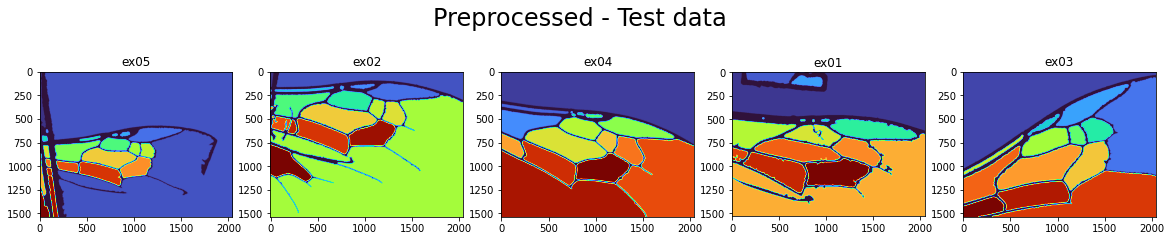

In [17]:
# Display images

plt.figure(figsize=(20, 4))
for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    
    plt.subplot(1, test_nb_images, i + 1)
    plt.imshow(test_preprocessed_img_list[i], cmap='turbo')
    plt.title(title)
    
plt.suptitle('Preprocessed - Test data', fontsize=24)
plt.show()

## Training data

In [18]:
train_preprocessed_img_list = []

for i in range(train_nb_images):
    title = train_title_list[i].split('/')[-1]
    print('Apply preprocessing on {}'.format(title))
    
    preprocessed_img = apply_preprocessing(train_img_list[i])
    train_preprocessed_img_list.append(preprocessed_img)

Apply preprocessing on 133 Lasioglossum nymphaerum f right 4x
Apply preprocessing on 193 Megachile latimanus f right 4x
Apply preprocessing on 1062 Agapostemon texanus f right 3.2x
Apply preprocessing on 842 Agapostemon texanus f right 3.2x
Apply preprocessing on 84 Lasioglossum MAWIspB f left 4x
Apply preprocessing on 385 Lasioglossum leucozonium f left 3.2x
Apply preprocessing on 1118 Osmia lignaria lignaria f right 4x
Apply preprocessing on 784 Lasioglossum zonulum f left 4x
Apply preprocessing on 004 Osmia lignaria f right 4x
Apply preprocessing on 7 Lasioglossum leucozonium f left 3.2x
Apply preprocessing on 913 Lasioglossum leucozonium f left 3.2x
Apply preprocessing on 62 Lasioglossum rohweri f right 4x
Apply preprocessing on 41 Lasioglossum rohweri f right 4x
Apply preprocessing on 119 Lasioglossum rohweri f left 4x
Apply preprocessing on 8 Lasioglossum zephyrum f left 4x
Apply preprocessing on 149 Lasioglossum rohweri f left 4x
Apply preprocessing on 105 Lasioglossum pilosum f

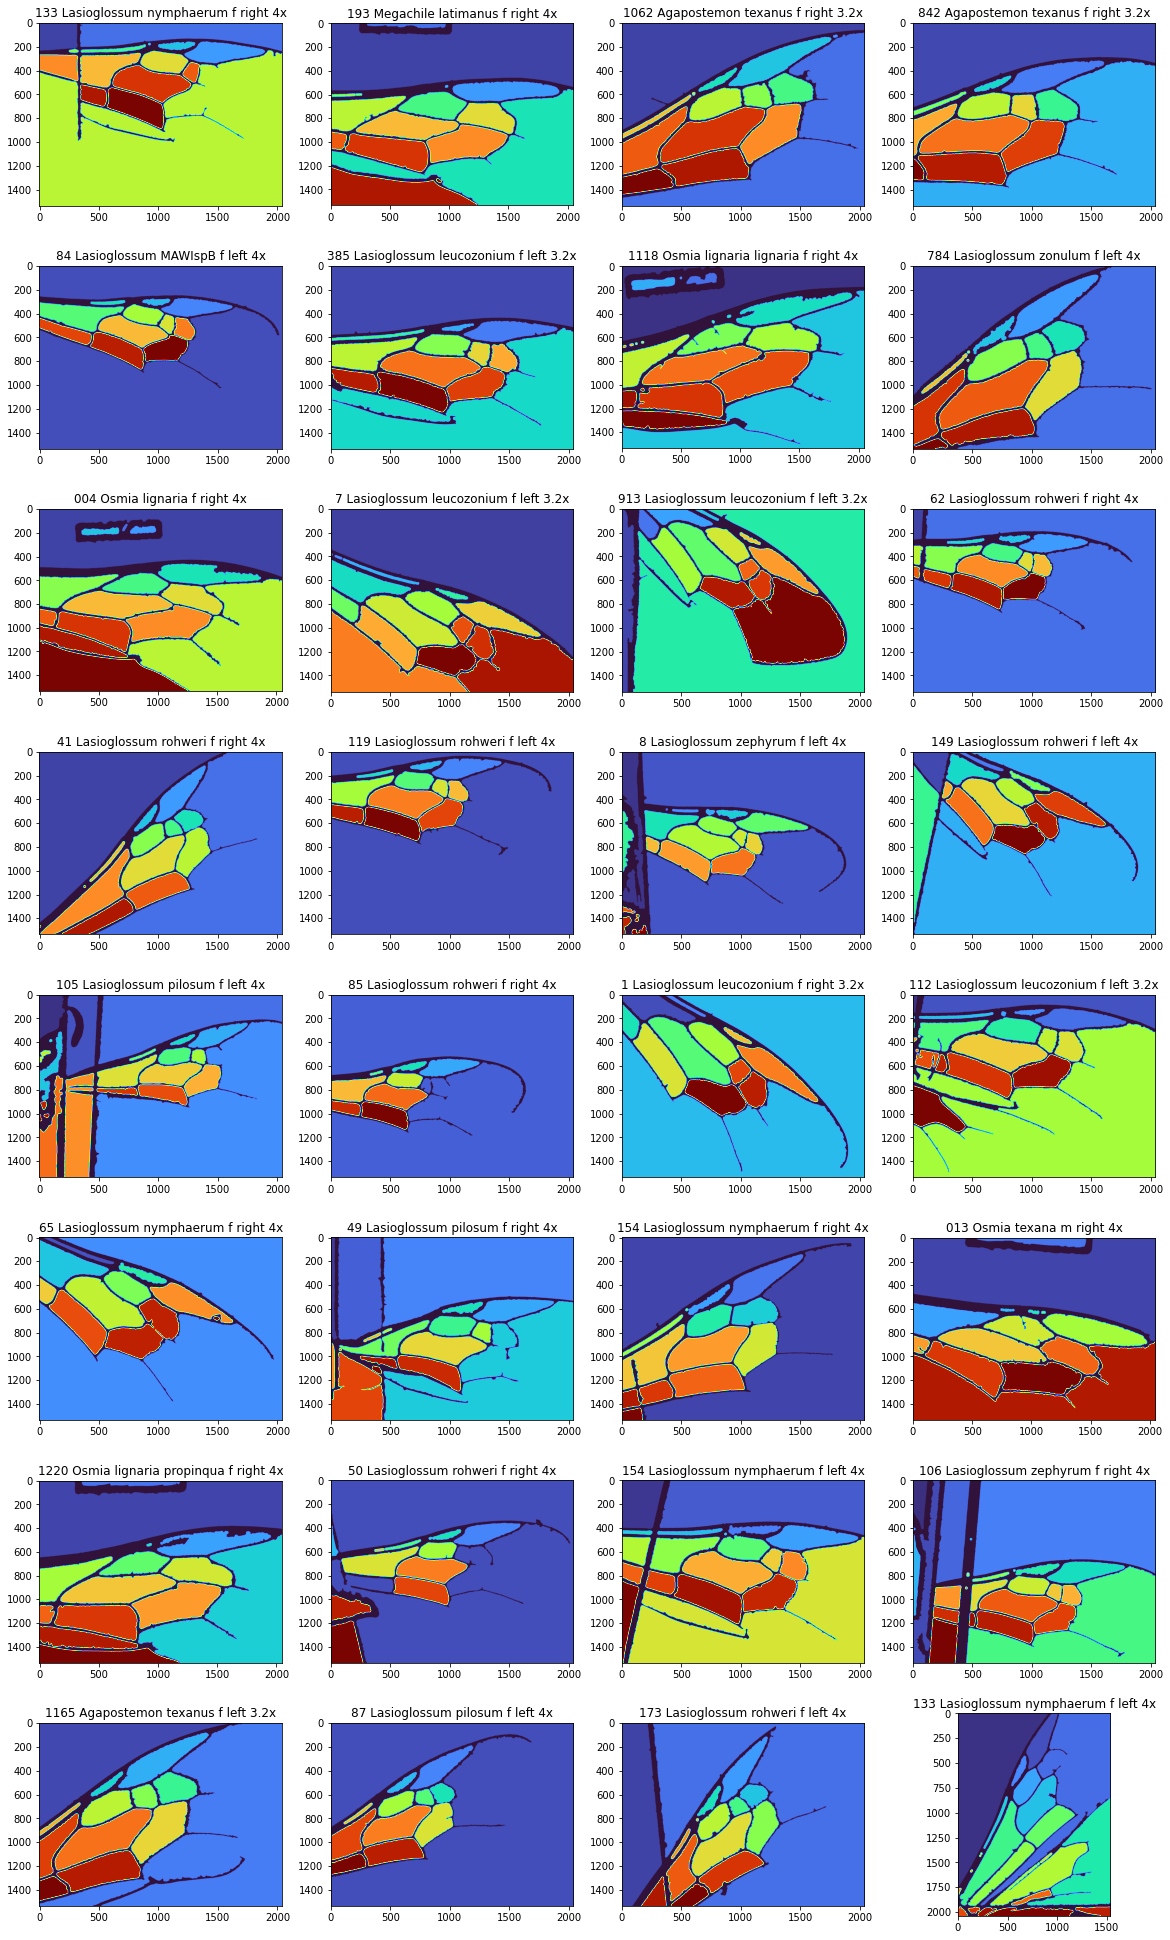

In [19]:
# Display 4 images per line

plt.figure(figsize=(20, 35))
for i in range(train_nb_images):
    title = train_title_list[i].split('/')[-1]
    
    plt.subplot(8, 4, i + 1)
    plt.imshow(train_preprocessed_img_list[i], cmap='turbo')
    plt.title(title)
    
plt.show()

# Intersections detection

In [20]:
def detect_intersection(img, window_size, min_count=20):
    shape = img.shape    
    h_window_size = window_size // 2
    intersections = pd.DataFrame(columns=[0, 1])
    
    # Iterate over the image as tiles
    # Step of h_window_size for the points between two tiles
    for i in range(0, shape[0] - window_size, h_window_size):
        for j in range(0, shape[1] - window_size, h_window_size):
            
            # Current image tile
            img_window = img[i:i+window_size, j:j+window_size]
            
            _, count = np.unique(img_window, return_counts=True)
            # Check if img_window contains at least 3 colors (components)
            # and each component contains more than min_count points
            if len(count[count > min_count]) > 3:
                intersections.loc[intersections.shape[0]] = [i + h_window_size, j + h_window_size]
            
    return intersections

In [21]:
def build_intersections_image(img, intersections):
    # Create new image from intersections dataframe
    img_zeros = np.zeros_like(img)
    for [x, y] in intersections.values.tolist():
        img_zeros[x, y] = 1
    return img_zeros

In [22]:
def merge_intersection_points(img, intersections, window_size, start_idx=0):
    shape = img.shape
    h_window_size = window_size // 2
    new_intersections = pd.DataFrame(columns=[0, 1])
    
    img_zeros = build_intersections_image(img, intersections)
    
    # Iterate over the image as tiles
    # Step of h_window_size for the points between two tiles
    for i in range(start_idx, shape[0] - window_size, window_size):
        for j in range(start_idx, shape[1] - window_size, window_size):
            
            # Current image tile
            img_window = img_zeros[i:i+window_size, j:j+window_size]
            
            components, _ = np.unique(img_window, return_counts=True)
            # Check if img_window contains 0 and 1
            if len(components) == 2:
                indices = np.argwhere(img_window == 1)
                # Compute mean x, y indices
                mean_x = int(np.mean(indices[:, 0]))
                mean_y = int(np.mean(indices[:, 1]))
                
                # Mean indices is given in the img_window, add the offset of i and j
                new_intersections.loc[new_intersections.shape[0]] = [i + mean_x, j + mean_y]
    
    return new_intersections

## Intersection detection on test data

In [23]:
test_intersection_list = []
window_size = 70

for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    print('Intersection detection on {}'.format(title))
    
    intersection = detect_intersection(test_preprocessed_img_list[i], window_size)
    intersection = merge_intersection_points(test_preprocessed_img_list[i], intersection, 100)
    intersection = merge_intersection_points(test_preprocessed_img_list[i], intersection, 80, start_idx=40)
    
    test_intersection_list.append(intersection)

Intersection detection on ex05
Intersection detection on ex02
Intersection detection on ex04
Intersection detection on ex01
Intersection detection on ex03


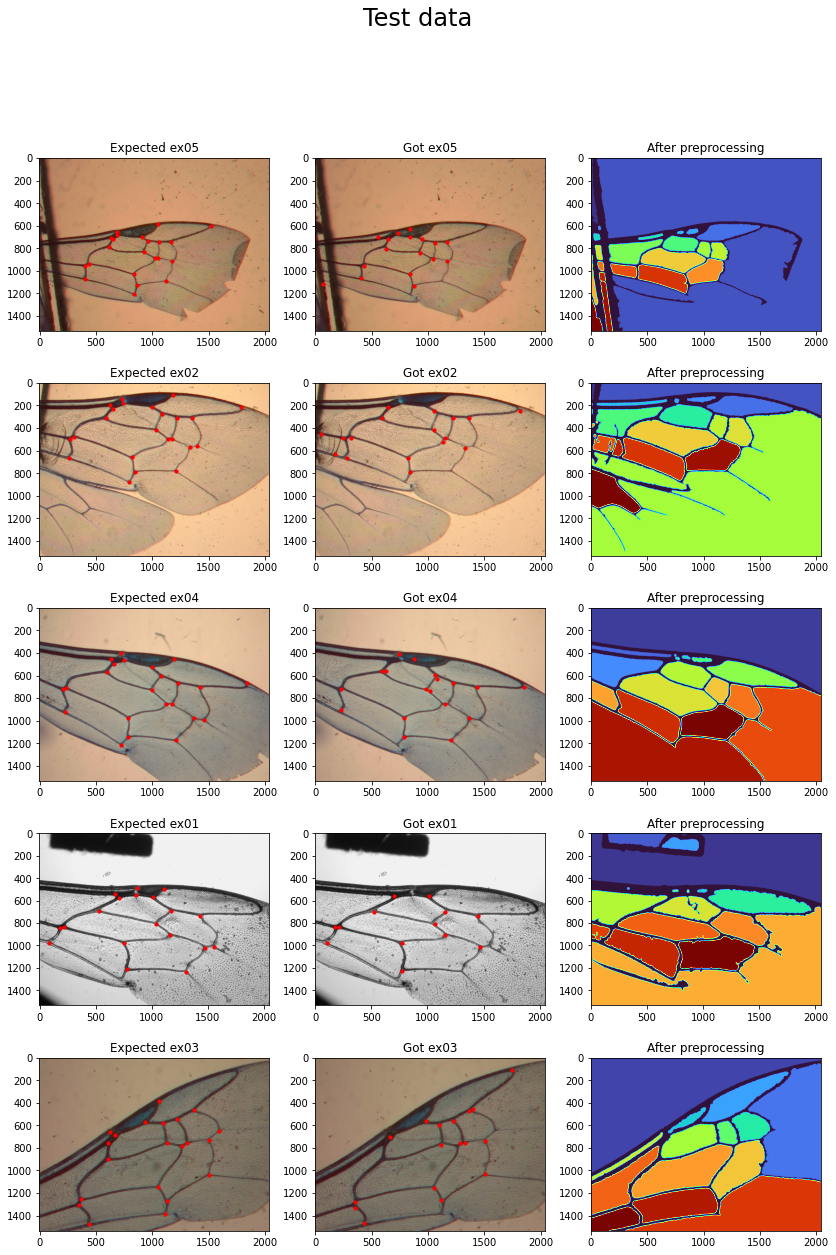

In [24]:
# Display images

plt.figure(figsize=(14, 20))
for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    
    plt.subplot(test_nb_images, 3, 3 * i + 1)
    plot_img(test_img_list[i], test_csv_list[i], 'Expected ' + title, scatter=10)
    
    plt.subplot(test_nb_images, 3, 3 * i + 2)
    plot_img(test_img_list[i], test_intersection_list[i], 'Got ' + title, scatter=10)
    
    plt.subplot(test_nb_images, 3, 3 * i + 3)
    plt.imshow(test_preprocessed_img_list[i], cmap='turbo')
    plt.title('After preprocessing')
    
plt.suptitle('Test data', fontsize=24)
plt.show()

## Intersection detection on train data

In [25]:
train_intersection_list = []
window_size = 70

for i in range(train_nb_images):
    title = train_title_list[i].split('/')[-1]
    print('Intersection detection on {}'.format(title))
    
    intersection = detect_intersection(train_preprocessed_img_list[i], window_size)
    intersection = merge_intersection_points(train_preprocessed_img_list[i], intersection, 100)
    intersection = merge_intersection_points(train_preprocessed_img_list[i], intersection, 80, start_idx=40)
    
    train_intersection_list.append(intersection)

Intersection detection on 133 Lasioglossum nymphaerum f right 4x
Intersection detection on 193 Megachile latimanus f right 4x
Intersection detection on 1062 Agapostemon texanus f right 3.2x
Intersection detection on 842 Agapostemon texanus f right 3.2x
Intersection detection on 84 Lasioglossum MAWIspB f left 4x
Intersection detection on 385 Lasioglossum leucozonium f left 3.2x
Intersection detection on 1118 Osmia lignaria lignaria f right 4x
Intersection detection on 784 Lasioglossum zonulum f left 4x
Intersection detection on 004 Osmia lignaria f right 4x
Intersection detection on 7 Lasioglossum leucozonium f left 3.2x
Intersection detection on 913 Lasioglossum leucozonium f left 3.2x
Intersection detection on 62 Lasioglossum rohweri f right 4x
Intersection detection on 41 Lasioglossum rohweri f right 4x
Intersection detection on 119 Lasioglossum rohweri f left 4x
Intersection detection on 8 Lasioglossum zephyrum f left 4x
Intersection detection on 149 Lasioglossum rohweri f left 4x
I

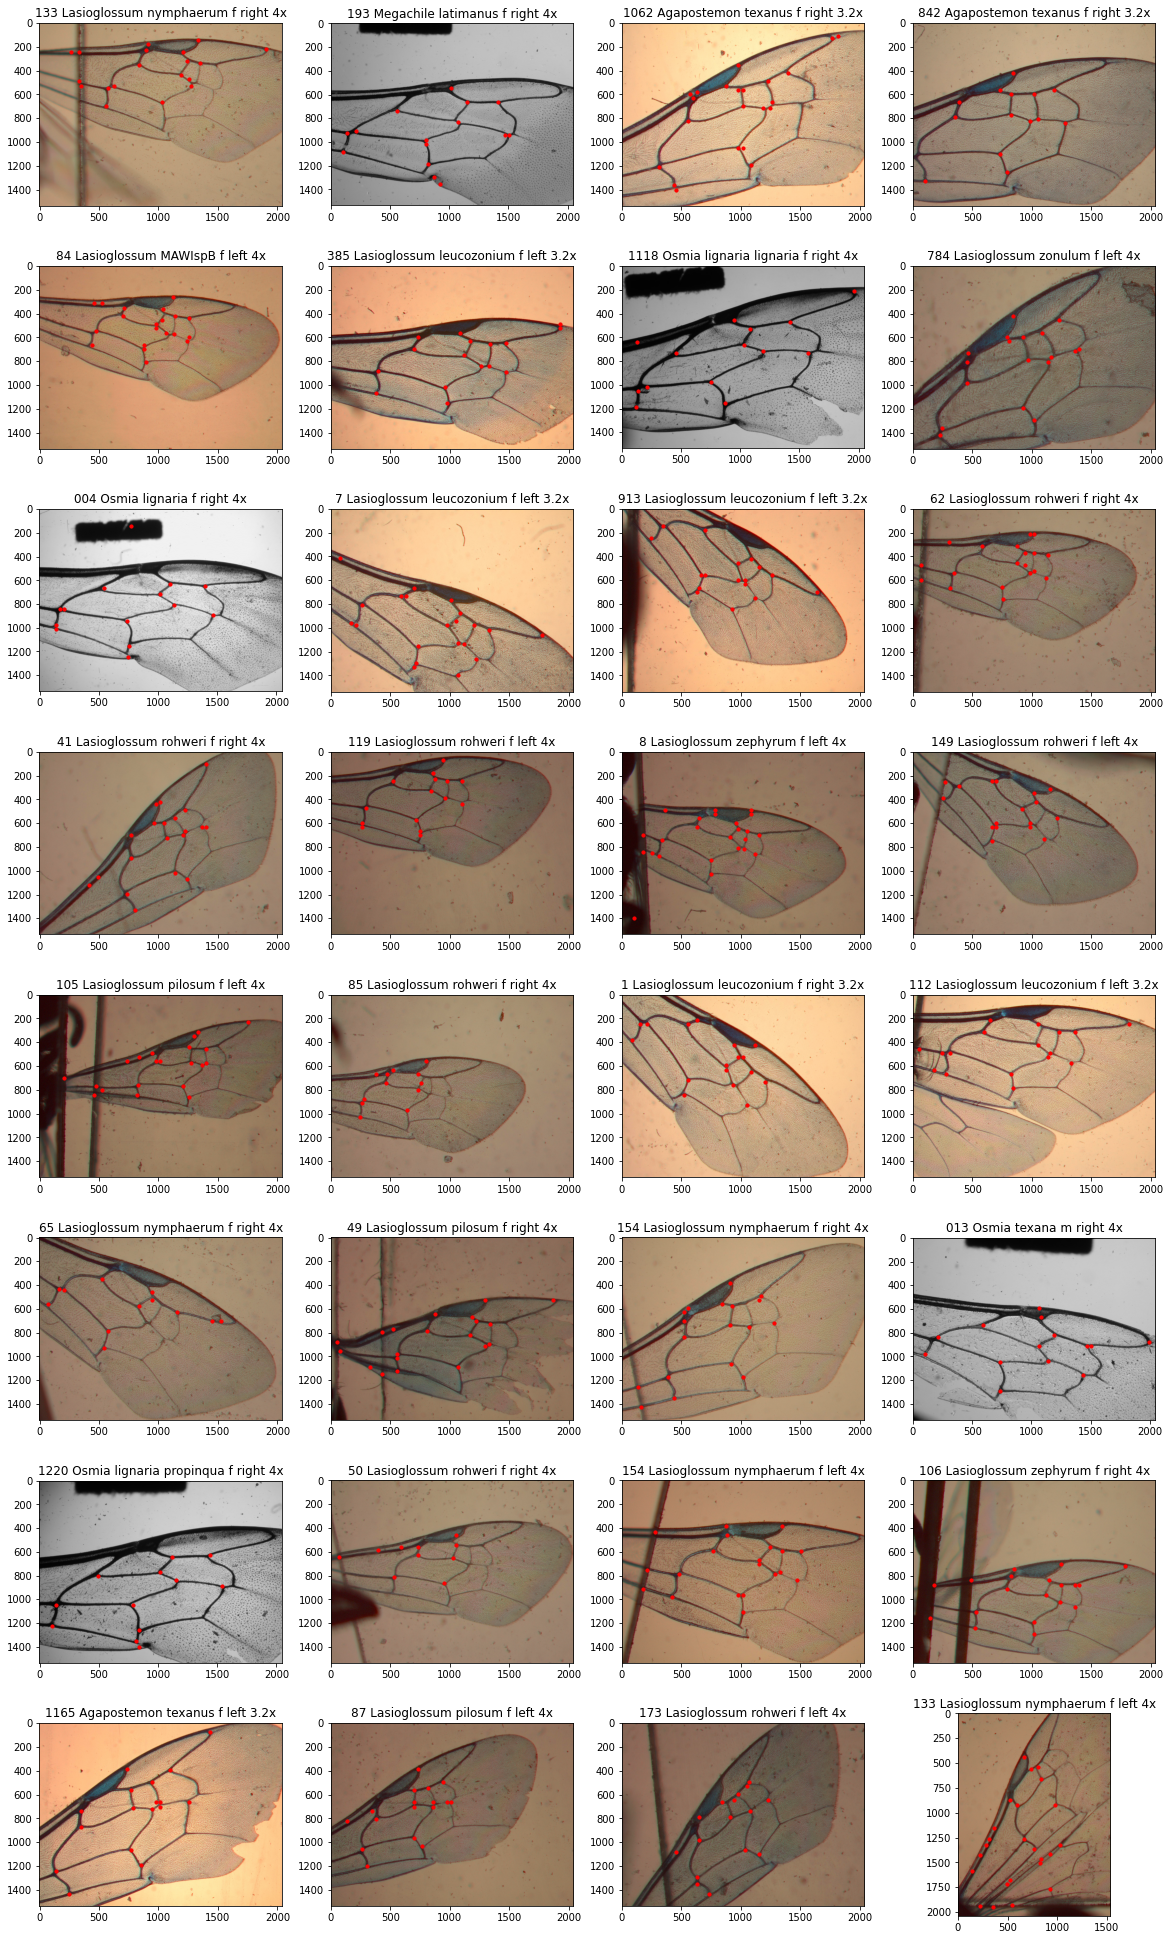

In [26]:
# Display 4 images per line

plt.figure(figsize=(20, 35))
for i in range(train_nb_images):
    title = train_title_list[i].split('/')[-1]
    
    plt.subplot(8, 4, i + 1)
    plot_img(train_img_list[i], train_intersection_list[i], scatter=10)
    plt.title(title)
    
plt.show()

# Score

In [27]:
def is_point_good(p_pred, y_true, error_px):
    '''
    Check if 'pred' is matching with one point of y_true
    '''
    nb_true = len(y_true)
    for idx in range(nb_true):
        p_true = (int(y_true.iloc[idx][0]), int(y_true.iloc[idx][1]))

        if abs(p_true[0] - p_pred[0]) < error_px and abs(p_true[1] - p_pred[1]):
            return True, idx

    return False, -1

def compute_score(y_preds, y_true, error_px):
    '''
    Compute accuracy / precision / recall and f1-score
    
    params:
        'y_preds': dataframe with all the predictions
        'y_true': dataframe with all the labels
    '''
    TP = 0
    nb_preds = len(y_preds)
    y_true_cpy = y_true.copy()
    for idx in range(nb_preds):
        p_pred = (int(y_preds.iloc[idx][0]), int(y_preds.iloc[idx][1]))

        is_good, idx_true = is_point_good(p_pred, y_true_cpy, error_px)
        if is_good:
            TP += 1
            y_true_cpy = y_true_cpy.drop([idx_true])
            y_true_cpy = y_true_cpy.reset_index()
            y_true_cpy = y_true_cpy.drop(columns=['index'])

    # compute precision (<=> accuracy in our case)
    # precision = TP / (TP + FP)
    precision = TP / nb_preds

    # compute recall (recall = TP / (TP + FN))
    recall = TP / len(y_true)

    # compute f1-score (f1-score = 2 * precision * recall / (precision + recall))
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1_score

In [28]:
def compute_scores_all_imgs(y_preds_list, y_true_list, title_list, error_px):
    m = len(y_preds_list)
    
    mean_p, mean_r, mean_f = 0, 0, 0
    for i in range(m):
        title = title_list[i].split('/')[-1]

        precision, recall, f1_score = compute_score(y_preds_list[i], y_true_list[i], error_px)
        mean_p += precision
        mean_r += recall
        mean_f += f1_score
        print("Precision: {:.5f} / Recall: {:.5f} / F1: {:.5f} | {}".format(precision, recall, f1_score, title))
    
    print()
    print("Mean precision: {:.5f}".format(mean_p / m))
    print("Mean recall: {:.5f}".format(mean_r / m))
    print("Mean f1_score: {:.5f}".format(mean_f / m))

In [29]:
compute_scores_all_imgs(test_intersection_list, test_csv_list, test_title_list, 30)

Precision: 0.94118 / Recall: 0.72727 / F1: 0.82051 | ex05
Precision: 0.88235 / Recall: 0.65217 / F1: 0.75000 | ex02
Precision: 0.83333 / Recall: 0.65217 / F1: 0.73171 | ex04
Precision: 1.00000 / Recall: 0.68421 / F1: 0.81250 | ex01
Precision: 0.88235 / Recall: 0.71429 / F1: 0.78947 | ex03

Mean precision: 0.90784
Mean recall: 0.68602
Mean f1_score: 0.78084


In [30]:
compute_scores_all_imgs(train_intersection_list, train_csv_list, train_title_list, 30)

Precision: 0.84211 / Recall: 0.76190 / F1: 0.80000 | 133 Lasioglossum nymphaerum f right 4x
Precision: 0.86667 / Recall: 0.68421 / F1: 0.76471 | 193 Megachile latimanus f right 4x
Precision: 0.72727 / Recall: 0.80000 / F1: 0.76190 | 1062 Agapostemon texanus f right 3.2x
Precision: 1.00000 / Recall: 0.66667 / F1: 0.80000 | 842 Agapostemon texanus f right 3.2x
Precision: 0.85000 / Recall: 0.85000 / F1: 0.85000 | 84 Lasioglossum MAWIspB f left 4x
Precision: 1.00000 / Recall: 0.76190 / F1: 0.86486 | 385 Lasioglossum leucozonium f left 3.2x
Precision: 0.92857 / Recall: 0.72222 / F1: 0.81250 | 1118 Osmia lignaria lignaria f right 4x
Precision: 0.83333 / Recall: 0.75000 / F1: 0.78947 | 784 Lasioglossum zonulum f left 4x
Precision: 0.71429 / Recall: 0.55556 / F1: 0.62500 | 004 Osmia lignaria f right 4x
Precision: 0.80952 / Recall: 0.80952 / F1: 0.80952 | 7 Lasioglossum leucozonium f left 3.2x
Precision: 0.88235 / Recall: 0.68182 / F1: 0.76923 | 913 Lasioglossum leucozonium f left 3.2x
Precisio

## Save results

In [31]:
def save_results(df, path):
    df.to_csv(path, sep=',', header=False, index=False)
    print('Save at {}'.format(path))

### Test data

In [32]:
# Save test results
for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    save_results(test_intersection_list[i], output_path + title + '.csv')

Save at ../RESULTS/ex05.csv
Save at ../RESULTS/ex02.csv
Save at ../RESULTS/ex04.csv
Save at ../RESULTS/ex01.csv
Save at ../RESULTS/ex03.csv


### Train data

In [33]:
# Save train results
for i in range(train_nb_images):
    title = train_title_list[i].split('/')[-1]
    save_results(train_intersection_list[i], output_path + 'TRAIN/' + title + '.csv')

Save at ../RESULTS/TRAIN/133 Lasioglossum nymphaerum f right 4x.csv
Save at ../RESULTS/TRAIN/193 Megachile latimanus f right 4x.csv
Save at ../RESULTS/TRAIN/1062 Agapostemon texanus f right 3.2x.csv
Save at ../RESULTS/TRAIN/842 Agapostemon texanus f right 3.2x.csv
Save at ../RESULTS/TRAIN/84 Lasioglossum MAWIspB f left 4x.csv
Save at ../RESULTS/TRAIN/385 Lasioglossum leucozonium f left 3.2x.csv
Save at ../RESULTS/TRAIN/1118 Osmia lignaria lignaria f right 4x.csv
Save at ../RESULTS/TRAIN/784 Lasioglossum zonulum f left 4x.csv
Save at ../RESULTS/TRAIN/004 Osmia lignaria f right 4x.csv
Save at ../RESULTS/TRAIN/7 Lasioglossum leucozonium f left 3.2x.csv
Save at ../RESULTS/TRAIN/913 Lasioglossum leucozonium f left 3.2x.csv
Save at ../RESULTS/TRAIN/62 Lasioglossum rohweri f right 4x.csv
Save at ../RESULTS/TRAIN/41 Lasioglossum rohweri f right 4x.csv
Save at ../RESULTS/TRAIN/119 Lasioglossum rohweri f left 4x.csv
Save at ../RESULTS/TRAIN/8 Lasioglossum zephyrum f left 4x.csv
Save at ../RESULT